In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm
import sklearn.naive_bayes
import sklearn.metrics
from sklearn.model_selection import train_test_split
import glob
import seaborn as sns
import os.path
import time
from sklearn.decomposition import PCA
from sklearn import feature_selection
import warnings
warnings.filterwarnings("ignore")  # Ignore sklearn deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)       # Ignore sklearn deprecation warnings

In [27]:
current_directory = os.path.dirname(os.getcwd())
project_directory = os.path.split(current_directory)[0]
dataset_directory = os.path.join(project_directory, 'datasets')

occupancy_dataset_directory = os.path.join(dataset_directory, '1_occupancy')
healthy_older_people_dataset_directory = os.path.join(dataset_directory, '2_healthy_older_people')
bitcoin_heist_ransonware_address_dataset_directory = os.path.join(dataset_directory, '3_bitcoin_heist_ransonware_address')
bank_additional_dataset_directory = os.path.join(dataset_directory, '4_bank_additional')
montreal_crime_dataset_directory = os.path.join(dataset_directory, '5_interventionscitoyendo')
credit_cards_dataset_directory = os.path.join(dataset_directory, '6_credit_cards')
census_income_dataset_directory = os.path.join(dataset_directory, '7_census_income')
yeast_dataset_directory = os.path.join(dataset_directory, '8_yeast')
magic_gamma_dataset_directory = os.path.join(dataset_directory, '9_magic_gamma')

print(os.listdir(dataset_directory))
print(occupancy_dataset_directory
      , healthy_older_people_dataset_directory
      , bitcoin_heist_ransonware_address_dataset_directory
      , bank_additional_dataset_directory)

['1_occupancy', '2_healthy_older_people', '3_bitcoin_heist_ransonware_address', '4_bank_additional', '5_interventionscitoyendo', '6_credit_cards', '7_census_income', '8_yeast', '9_magic_gamma', 'urls.txt']
C:\Users\manjo\Documents\GitHub\COMP-6321-ML\datasets\1_occupancy C:\Users\manjo\Documents\GitHub\COMP-6321-ML\datasets\2_healthy_older_people C:\Users\manjo\Documents\GitHub\COMP-6321-ML\datasets\3_bitcoin_heist_ransonware_address C:\Users\manjo\Documents\GitHub\COMP-6321-ML\datasets\4_bank_additional


In [28]:
le = sklearn.preprocessing.LabelEncoder()
svm_info = []
naive_bayes_info=[]

In [29]:
## SVM classification model with deafult values
def svm_classification(X_train,y_train,X_test,y_test):
    start = time.time()
    svm_model = sklearn.svm.SVC(random_state=0,probability=True)
    svm_model.fit(X_train,y_train)
    t = time.time()-start
    return svm_model,t;

In [30]:
## SVM classification using GRID SEARCH CV
def svm_classification_tuned(X_train,y_train):
    start = time.time()
    svm_model = sklearn.svm.SVC(kernel = 'rbf',probability=True)
    c = np.logspace(-1,2,4)
    gamma = np.logspace(-3,1,4)   
    param_grid = { 'C':c,'gamma':gamma}
    svm_model_gs = sklearn.model_selection.GridSearchCV(svm_model,param_grid,verbose=1,cv=3) 
    svm_model_gs.fit(X_train,y_train)
    t = time.time()-start
    return svm_model_gs.best_estimator_,t;

In [31]:
## Gaussian classification model 
def gaussian_classification(X_train,y_train,X_test,y_test,probs):
    start = time.time()
    gnb_model = sklearn.naive_bayes.GaussianNB(priors=probs)
    gnb_model.fit(X_train,y_train)
    t = time.time()-start
    return gnb_model,t;

In [111]:
## Plot different features densities categorised by class.
def plot_feature_outcome_corr(data,palette):
    i=1
    rows = np.ceil(len(data.columns)/3)
    
    for j in range(0,len(data.columns)-1):
        if( (i-1) %3.0 == 0):
            fig = plt.figure(figsize=(16,rows*5)) 
        ax = plt.subplot(rows, 3, i) 
        g = sns.FacetGrid(data, hue=data.columns[-1],palette=palette)
        g.map(sns.distplot,data.columns[j] , kde=False, bins=15,ax=ax)
        plt.title('{:s}'.format(data.columns[j]))
        ax.legend(title=data.columns[-1])
        i = i+1
        plt.close()

In [33]:
# Models ROC AUC plotting code
def plotModel (model,X_train,y_train,X_test,y_test):
    
    y_predicttrain = model.predict(X_train)
    y_predicttest = model.predict(X_test)
    ac_train=sklearn.metrics.accuracy_score(y_train, y_predicttrain)*100
    ac_test=sklearn.metrics.accuracy_score(y_test, y_predicttest)*100
    if np.unique(y_train).size>2:
        lb = sklearn.preprocessing.LabelBinarizer()
        y_test=lb.fit_transform(y_test)
        y_predicttest=lb.transform(y_predicttest)
        
        roc=sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr", average="weighted")*100        
    else:
        roc=sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])*100
        
        sklearn.metrics.plot_roc_curve(model, X_test, y_test)
    return ac_train,ac_test,roc

In [34]:
#Models trained on data after scaling using MinMaxScaler
def model_normalised(m,X_train,y_train,X_test,y_test,probs):
    plt.figure()
    minmax = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_minmaxed = minmax.fit_transform(X_train)
    X_test_minmaxed = minmax.fit_transform(X_test)
   
    if m == 'svm':
        model,tym = svm_classification(X_minmaxed,y_train,X_test_minmaxed,y_test)
    elif m== 'gnb':
        model,tym = gaussian_classification(X_minmaxed,y_train,X_test_minmaxed,y_test,probs)
    train_acc,test_acc,roc = evalModel(model,X_minmaxed,y_train,X_test_minmaxed,y_test)
    
    print(model)
    print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
    print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
    print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
    print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
 


In [123]:
#Models trained on data after reducing dimensionality using Principal Component Analysis
def model_pca(m,X_train,y_train,X_test,y_test,probs):
    minmax = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_minmaxed = minmax.fit_transform(X_train)
    X_test_minmaxed = minmax.fit_transform(X_test)
    pca = PCA(n_components='mle',random_state=0)
    X_pca = pca.fit_transform(X_minmaxed)
    X_test_pca = pca.fit_transform(X_test_minmaxed)
    if m == 'svm':
        model,tym = svm_classification(X_pca,y_train,X_test_pca,y_test)
    elif m== 'gnb':
        model,tym = gaussian_classification(X_pca,y_train,X_test_pca,y_test,probs)
    train_acc,test_acc,roc = evalModel(model,X_pca,y_train,X_test_pca,y_test)
    print(model)
    print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
    print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
    print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
    print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

In [121]:
#Models trained on data after reducing dimensionality using Variance threshold
def model_variance(m,X_train,y_train,X_test,y_test,probs):    
    var = sklearn.feature_selection.VarianceThreshold(threshold=0.8)
    X_red = var.fit_transform(X_train)
    X_test_red = var.fit_transform(X_test)
    if m == 'svm':
        model,tym = svm_classification(X_red,y_train,X_test_red,y_test)
    elif m== 'gnb':
        model,tym = gaussian_classification(X_red,y_train,X_test_red,y_test,probs)
    train_acc,test_acc,roc = evalModel(model,X_red,y_train,X_test_red,y_test)
    print(model)
    print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
    print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
    print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
    print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

In [89]:
# Method to print results of all three feature transformation techniques
def evalModel (model,X_train,y_train,X_test,y_test):    
    y_predicttrain = model.predict(X_train)
    y_predicttest = model.predict(X_test)
    ac_train=sklearn.metrics.accuracy_score(y_train, y_predicttrain)*100
    ac_test=sklearn.metrics.accuracy_score(y_test, y_predicttest)*100
    if np.unique(y_train).size>2:
        lb = sklearn.preprocessing.LabelBinarizer()
        y_test=lb.fit_transform(y_test)
        y_predicttest=lb.transform(y_predicttest)
        
        roc=sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr", average="weighted")*100        
    else:
        roc=sklearn.metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])*100
    return ac_train,ac_test,roc

In [90]:
# One stop method to call all three feature transformation techniques on one sataset for one model.
def plot(m,X_train,y_train,X_test,y_test,probs):
    print("Normalisation")
    model_normalised(m,X_train,y_train,X_test,y_test,probs)
    
    print("\nPCA")
    
    model_pca(m,X_train,y_train,X_test,y_test,probs)
    print("\nVariance Threshhold")
    
    model_variance(m,X_train,y_train,X_test,y_test,probs)
    


 ## 1.OCCUPANCY DATASET


### Data Loading

In [121]:
training_dataset_url = os.path.join(occupancy_dataset_directory, 'occupancy_data', 'datatraining.txt')
test_dataset_url = os.path.join(occupancy_dataset_directory, 'occupancy_data', 'datatest.txt')

data_occupancy = np.loadtxt(training_dataset_url,delimiter=',', skiprows=1, usecols = (2,3,4,5,6,7))
data_occupany_test=np.loadtxt(test_dataset_url, delimiter=',', skiprows=1, usecols = (2,3,4,5,6,7))
X_train=data_occupancy[:, 0:5]
y_train=data_occupancy[:, 5].astype(np.int32)
X_test=data_occupany_test[:, 0:5]
y_test=data_occupany_test[:, 5].astype(np.int32)

### Plot Feature-Outcome correlation

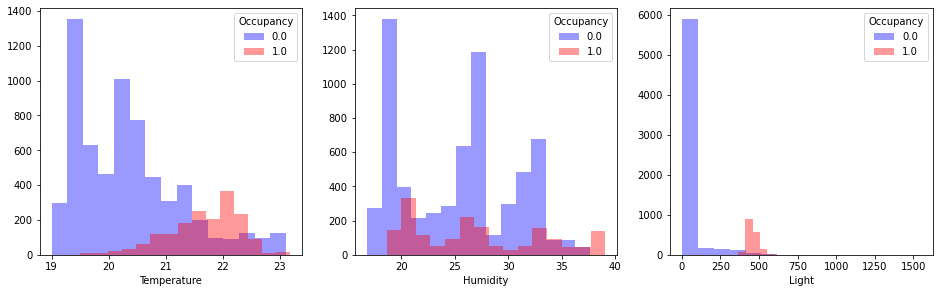

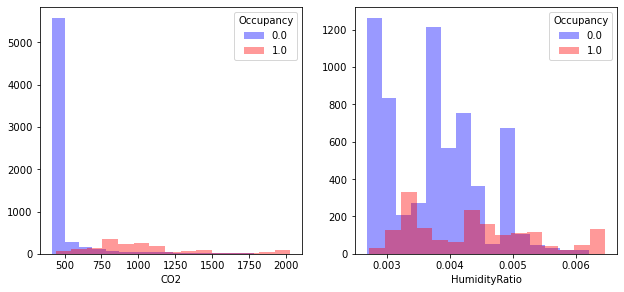

In [122]:
cols = ['Temperature','Humidity','Light','CO2','HumidityRatio','Occupancy']
data = pd.DataFrame(data=data_occupancy,columns=cols)
palette={0: "b", 1: "r"}
plot_feature_outcome_corr(data,palette)

### Model Evaluation

### SVM Classifier

SVC(probability=True, random_state=0)
Elapsed time:            1.1001 sec
Training accuracy score: 98.8702%
Test accuracy score:     97.6735%
ROC AUC score:           98.3619%


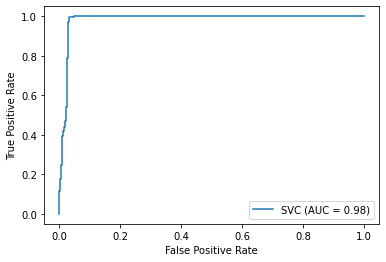

In [13]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print(model)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

### SVM using GRIDSEARCH

In [17]:
#np.random.shuffle(data_occupancy)
model,tym = svm_classification_tuned(X_train,y_train)
print(model)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 10.5min finished


SVC(C=0.1, gamma=0.001, probability=True)


Elapsed time:            1.1001 sec
Training accuracy score: 98.8702%
Test accuracy score:     97.6735%
ROC AUC score:           98.3619%


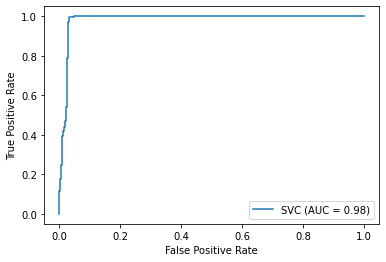

In [14]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

Elapsed time:            0.0072 sec
Training accuracy score: 97.8018%
Test accuracy score:     97.7486%
ROC AUC score:           98.9499%


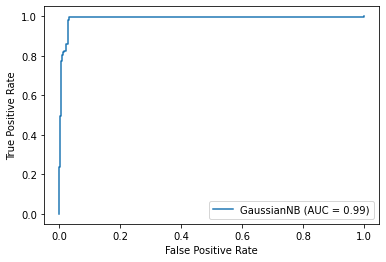

In [125]:
prob_0 = y_train[y_train ==0].shape[0]/y_train.shape[0]
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
probs = np.array([prob_0,prob_1])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

### SVM performance on feature processing and dimensionality reduction

In [124]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            0.9278 sec
Training accuracy score: 98.8948%
Test accuracy score:     97.5985%
ROC AUC score:           97.5749%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            1.0040 sec
Training accuracy score: 98.8948%
Test accuracy score:     90.9568%
ROC AUC score:           98.3605%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            1.3258 sec
Training accuracy score: 98.8579%
Test accuracy score:     97.6735%
ROC AUC score:           98.4727%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [126]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.78767039, 0.21232961]))
Elapsed time:            0.0064 sec
Training accuracy score: 97.8878%
Test accuracy score:     95.4597%
ROC AUC score:           99.0679%

PCA
GaussianNB(priors=array([0.78767039, 0.21232961]))
Elapsed time:            0.0041 sec
Training accuracy score: 97.7281%
Test accuracy score:     85.1782%
ROC AUC score:           99.1728%

Variance Threshhold
GaussianNB(priors=array([0.78767039, 0.21232961]))
Elapsed time:            0.0040 sec
Training accuracy score: 97.8018%
Test accuracy score:     97.7486%
ROC AUC score:           98.9500%


<Figure size 432x288 with 0 Axes>

## 2.BANK MARKETTING

### Data Loading

In [112]:
training_dataset_url = os.path.join(bank_additional_dataset_directory, 'bank-additional', 'bank-additional', 'bank-additional-full.csv')
test_dataset_url = os.path.join(bank_additional_dataset_directory, 'bank-additional', 'bank-additional', 'bank-additional.csv')


data_bank = pd.read_csv(training_dataset_url, delimiter=';')
data_bank_test= pd.read_csv(test_dataset_url, delimiter=';')

In [113]:


for i in [1,2,3,4,5,6,7,8,9,14]:
    data_bank.iloc[:,i] = le.fit_transform(data_bank.iloc[:,i])
    data_bank_test.iloc[:,i] = le.fit_transform(data_bank_test.iloc[:,i])
    
bank_labels ={'no':0,'yes':1}
data_bank.y = [bank_labels[i] for i in data_bank.y]
data_bank_test.y = [bank_labels[i] for i in data_bank_test.y]

X_train = data_bank.iloc[:,:-1]
y_train = data_bank.iloc[:,-1].astype('int32')

X_test = data_bank_test.iloc[:,:-1]
y_test = data_bank_test.iloc[:,-1].astype('int32')


### Plot Feature-Outcome correlation

In [115]:
# palette ={0: "b", 1: "r"}
# plot_feature_outcome_corr(data_bank,palette)

### Model Evaluation

### SVM

Elapsed time:            334.6395 sec
Training accuracy score: 89.7956%
Test accuracy score:     90.0947%
ROC AUC score:           92.3197%


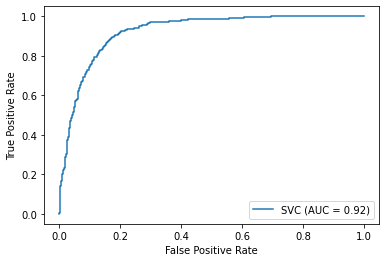

In [130]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

### SVM using GRIDSEARCH

In [131]:
# model,tym = svm_classification_tuned(X_train,y_train)
# print(model)

In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

Elapsed time:            0.0351 sec
Training accuracy score: 84.6557%
Test accuracy score:     84.6565%
ROC AUC score:           84.7305%


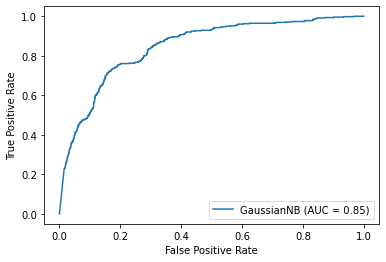

In [135]:
prob_0 = y_train[y_train ==0].shape[0]/y_train.shape[0]
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
probs = np.array([prob_0,prob_1])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

### SVM performance on feature processing and dimensionality reduction

In [134]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            361.4919 sec
Training accuracy score: 90.6453%
Test accuracy score:     91.4542%
ROC AUC score:           94.2480%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            352.5721 sec
Training accuracy score: 90.9343%
Test accuracy score:     88.5895%
ROC AUC score:           64.6298%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            258.9377 sec
Training accuracy score: 89.7931%
Test accuracy score:     90.0947%
ROC AUC score:           92.3160%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [136]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.88734583, 0.11265417]))
Elapsed time:            0.0333 sec
Training accuracy score: 84.6557%
Test accuracy score:     83.6611%
ROC AUC score:           87.2606%

PCA
GaussianNB(priors=array([0.88734583, 0.11265417]))
Elapsed time:            0.0463 sec
Training accuracy score: 87.7610%
Test accuracy score:     84.5108%
ROC AUC score:           78.9282%

Variance Threshhold
GaussianNB(priors=array([0.88734583, 0.11265417]))
Elapsed time:            0.0343 sec
Training accuracy score: 88.1616%
Test accuracy score:     88.1039%
ROC AUC score:           88.5919%


<Figure size 432x288 with 0 Axes>

## 3.ACTIVITY RECOGNITION IN HEALTHY OLD PEOPLE

### Data Loading

In [94]:
files = glob.glob(os.path.join(healthy_older_people_dataset_directory, 'Datasets_Healthy_Older_People', 'datasets', "S1_Dataset", "d*"))
files.extend(glob.glob(os.path.join(healthy_older_people_dataset_directory, 'Datasets_Healthy_Older_People', 'datasets', "S2_Dataset", "d*")))


ar_files = [pd.read_csv(f, header=None) for f in files]
data_ar=pd.concat(ar_files,ignore_index=True).values

X=data_ar[:, 1:8]
y=data_ar[:, 8].astype('int32')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Plot Feature-Outcome correlation

In [116]:
# cols =['AccFrontal','AccVertical','AccLateral','IdSensor','RSSI','Phase','Frequency','ActivityLabel']
# palette = {1: "b", 2: "r",3:"olive",4:"g"}
# data = pd.DataFrame(data =np.hstack((X_train,y_train.reshape(-1,1))),columns=cols )
# plot_feature_outcome_corr(data,palette)

### Model Evaluation

### SVM

In [21]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            542.4185 sec
Training accuracy score: 68.6217%
Test accuracy score:     68.3948%
ROC AUC score:           98.1857%


### SVM using GRIDSEARCH

In [ ]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model)

In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE  BAYES

In [138]:
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
prob_2 = y_train[y_train ==2].shape[0]/y_train.shape[0]
prob_3 = y_train[y_train ==3].shape[0]/y_train.shape[0]
prob_4 = y_train[y_train ==4].shape[0]/y_train.shape[0]
probs = np.array([prob_1,prob_2,prob_3,prob_4])

model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            0.0229 sec
Training accuracy score: 94.1616%
Test accuracy score:     94.3431%
ROC AUC score:           99.3677%


### SVM performance on feature processing and dimensionality reduction

In [ ]:
plot('svm',X_train,y_train,X_test,y_test,None)

### GNB performance on feature processing and dimensionality reduction

In [139]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.21629896, 0.06553858, 0.68754784, 0.03061462]))
Elapsed time:            0.0176 sec
Training accuracy score: 94.1616%
Test accuracy score:     90.9091%
ROC AUC score:           98.9798%

PCA
GaussianNB(priors=array([0.21629896, 0.06553858, 0.68754784, 0.03061462]))
Elapsed time:            0.0236 sec
Training accuracy score: 92.0968%
Test accuracy score:     49.7338%
ROC AUC score:           41.8488%

Variance Threshhold
GaussianNB(priors=array([0.21629896, 0.06553858, 0.68754784, 0.03061462]))
Elapsed time:            0.0280 sec
Training accuracy score: 73.2355%
Test accuracy score:     72.7539%
ROC AUC score:           76.5977%


<Figure size 432x288 with 0 Axes>

## 4.BITCOIN HEIST DATA

### Data Loading

In [145]:
training_dataset_url = os.path.join(bitcoin_heist_ransonware_address_dataset_directory, 'data', 'BitcoinHeistData.csv')

data_bitcoin =pd.read_csv(training_dataset_url,nrows=100000)

bitcoin_labels = {'princetonCerber':1, 'princetonLocky':1, 'montrealCryptoLocker':1,
 'montrealCryptXXX':1, 'paduaCryptoWall':1, 'montrealWannaCry':1,
 'montrealDMALockerv3':1, 'montrealCryptoTorLocker2015':1, 'montrealSamSam':1,
 'montrealFlyper':1, 'montrealNoobCrypt':1, 'montrealDMALocker':1, 'montrealGlobe':1,
 'montrealEDA2':1, 'paduaKeRanger':1, 'montrealVenusLocker':1, 'montrealXTPLocker':1,
 'paduaJigsaw':1, 'montrealGlobev3':1, 'montrealJigSaw':1, 'montrealXLockerv5.0':1,
 'montrealXLocker':1, 'montrealRazy':1, 'montrealCryptConsole':1,
 'montrealGlobeImposter':1, 'montrealSam':1, 'montrealComradeCircle':1,
 'montrealAPT':1, 'white':0}
data_bitcoin.label = [bitcoin_labels[i] for i in data_bitcoin.label]
X = data_bitcoin.iloc[:,:-1]
y= data_bitcoin.iloc[:,-1]

le = sklearn.preprocessing.LabelEncoder()
X.iloc[:,0] = le.fit_transform(X.iloc[:,0])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

### Model Evaluation

### SVM

Elapsed time:            3216.4735 sec
Training accuracy score: 70.7189%
Test accuracy score:     70.1400%
ROC AUC score:           81.2068%


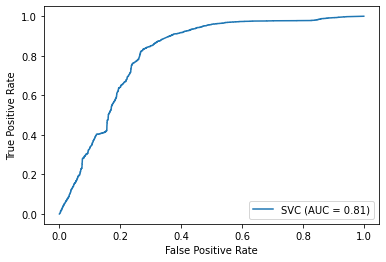

In [24]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

### SVM using GRIDSEARCH

In [ ]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model)

In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

Elapsed time:            0.0409 sec
Training accuracy score: 43.4644%
Test accuracy score:     42.9300%
ROC AUC score:           70.7136%


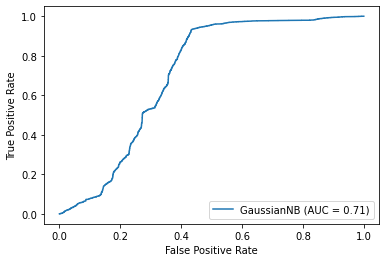

In [146]:
prob_0 = y_train[y_train ==0].shape[0]/y_train.shape[0]
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
probs = np.array([prob_0,prob_1])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

### GNB performance on feature processing and dimensionality reduction

In [147]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.5854, 0.4146]))
Elapsed time:            0.0339 sec
Training accuracy score: 99.3578%
Test accuracy score:     72.8600%
ROC AUC score:           86.1125%

PCA
GaussianNB(priors=array([0.5854, 0.4146]))
Elapsed time:            0.0319 sec
Training accuracy score: 96.0156%
Test accuracy score:     66.8900%
ROC AUC score:           59.9833%

Variance Threshhold
GaussianNB(priors=array([0.5854, 0.4146]))
Elapsed time:            0.0279 sec
Training accuracy score: 43.4644%
Test accuracy score:     42.9300%
ROC AUC score:           70.7136%


<Figure size 432x288 with 0 Axes>

## 5. MONTREAL CRIME DATASET

### Data Loading

In [117]:
le = sklearn.preprocessing.LabelEncoder()
training_dataset_url = os.path.join(montreal_crime_dataset_directory, 'interventionscitoyendo.csv')

category_mapping = {'Introduction':1, 'Vol dans / sur véhicule à moteur':2, 'Vol de véhicule à moteur':3, 'Méfait':4, 'Vol qualifié':5, 'Infraction entraînant la mort':6, 'Vols qualifiés':5, 'Infractions entrainant la mort':6}

data_mtlcrime = pd.read_csv(training_dataset_url,encoding='latin1',nrows=30000).replace(category_mapping)
data_mtlcrime['YEAR']=data_mtlcrime.DATE.str.split('-').str[0].astype(np.int32)
data_mtlcrime['MONTH']=data_mtlcrime.DATE.str.split('-').str[1].astype(np.int32)
data_mtlcrime['DAY']=data_mtlcrime.DATE.str.split('-').str[2].astype(np.int32)
data_mtlcrime.dropna(inplace=True)
X = data_mtlcrime.iloc[:,[i for i in range(2,11)]]
X.iloc[:,0] = le.fit_transform(X.iloc[:,0])

y = data_mtlcrime.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Plot

In [13]:
# palette = {1: "b", 2: "r",3:"olive",4:"g",5:'y',6:'orange'}
# plot_feature_outcome_corr(pd.concat([X,y],axis=1),palette)

### Model Evaluation

### SVM

In [27]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            219.3469 sec
Training accuracy score: 33.7875%
Test accuracy score:     33.0667%
ROC AUC score:           47.3449%


### SVM using GRIDSEARCH

In [ ]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model)

In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

In [150]:
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
prob_2 = y_train[y_train ==2].shape[0]/y_train.shape[0]
prob_3 = y_train[y_train ==3].shape[0]/y_train.shape[0]
prob_4 = y_train[y_train ==4].shape[0]/y_train.shape[0]
prob_5 = y_train[y_train ==5].shape[0]/y_train.shape[0]
prob_6 = y_train[y_train ==6].shape[0]/y_train.shape[0]
probs = np.array([prob_1,prob_2,prob_3,prob_4,prob_5,prob_6])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            0.0110 sec
Training accuracy score: 33.3125%
Test accuracy score:     33.7333%
ROC AUC score:           53.0975%


### SVM performance on feature processing and dimensionality reduction

In [118]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            461.5162 sec
Training accuracy score: 34.8875%
Test accuracy score:     35.2833%
ROC AUC score:           59.0962%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            462.4843 sec
Training accuracy score: 35.6708%
Test accuracy score:     35.1000%
ROC AUC score:           58.7170%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            328.1699 sec
Training accuracy score: 33.6958%
Test accuracy score:     33.4333%
ROC AUC score:           48.3325%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [151]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.334625  , 0.26325   , 0.13370833, 0.22375   , 0.04383333,
       0.00083333]))
Elapsed time:            0.0069 sec
Training accuracy score: 6.7333%
Test accuracy score:     7.3167%
ROC AUC score:           50.8087%

PCA
GaussianNB(priors=array([0.334625  , 0.26325   , 0.13370833, 0.22375   , 0.04383333,
       0.00083333]))
Elapsed time:            0.0140 sec
Training accuracy score: 33.4917%
Test accuracy score:     34.0333%
ROC AUC score:           57.6897%

Variance Threshhold
GaussianNB(priors=array([0.334625  , 0.26325   , 0.13370833, 0.22375   , 0.04383333,
       0.00083333]))
Elapsed time:            0.0070 sec
Training accuracy score: 33.3125%
Test accuracy score:     33.7333%
ROC AUC score:           53.0975%


<Figure size 432x288 with 0 Axes>

## 6.CREDIT CARDS DATA

### Data Loading

In [91]:
training_dataset_url = os.path.join(credit_cards_dataset_directory, 'default_of_credit_card_clients.csv')
data_creditcards = pd.read_csv(training_dataset_url,skiprows=1,usecols=[i for i in range(1,25)])

In [92]:
X = data_creditcards.iloc[:,:-1]
y= data_creditcards.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Model Evaluation

### SVM

Elapsed time:            183.7660 sec
Training accuracy score: 77.7375%
Test accuracy score:     78.5500%
ROC AUC score:           54.6908%


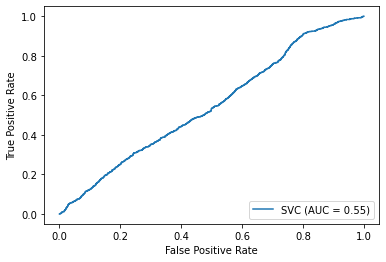

In [31]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

### SVM using GRIDSEARCH

In [ ]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model)

In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

Elapsed time:            0.0209 sec
Training accuracy score: 38.4375%
Test accuracy score:     37.4333%
ROC AUC score:           65.2361%


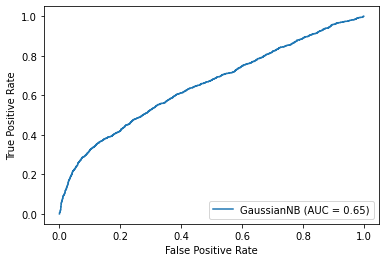

In [154]:
prob_0 = y_train[y_train ==0].shape[0]/y_train.shape[0]
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
probs = np.array([prob_0,prob_1])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

### SVM performance on feature processing and dimensionality reduction

In [93]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            179.3259 sec
Training accuracy score: 81.8708%
Test accuracy score:     82.0833%
ROC AUC score:           69.4201%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            166.1663 sec
Training accuracy score: 82.2625%
Test accuracy score:     78.9333%
ROC AUC score:           66.4352%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            185.3205 sec
Training accuracy score: 77.9333%
Test accuracy score:     77.8333%
ROC AUC score:           56.9941%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [155]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.7775, 0.2225]))
Elapsed time:            0.0189 sec
Training accuracy score: 67.2583%
Test accuracy score:     65.0667%
ROC AUC score:           71.3895%

PCA
GaussianNB(priors=array([0.7775, 0.2225]))
Elapsed time:            0.0149 sec
Training accuracy score: 57.6083%
Test accuracy score:     54.3500%
ROC AUC score:           62.7289%

Variance Threshhold
GaussianNB(priors=array([0.7775, 0.2225]))
Elapsed time:            0.0199 sec
Training accuracy score: 38.4542%
Test accuracy score:     37.4667%
ROC AUC score:           65.2396%


<Figure size 432x288 with 0 Axes>

## 7. CENSUS INCOME DATASET

### Data Loading

In [119]:
dataset_url = os.path.join(census_income_dataset_directory, 'adult_data.csv')

salary_mapping = {'<=50K':0, '>50K':1}
cols=['age','workclass','fnlwght','education','edu-num','marital-status','occupation','relationship','race','sex','capital-gain',
      'capital-loss','hours-per-week','country','income']
data_census=pd.read_csv(dataset_url, encoding='utf8', names=cols)
data_census = data_census.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)
data_census.income = [salary_mapping[i] for i in data_census.income]
data_census = data_census.replace(to_replace='?', value=np.nan)
data_census.dropna(inplace=True)

X = data_census.iloc[:,:-1]
for i in [1,3,5,6,7,8,9,13]:
    X.iloc[:,i] = le.fit_transform(X.iloc[:,i])
y = data_census.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Plot 

In [98]:
# palette = {0:"r",1:"b"}
# plot_feature_outcome_corr(pd.concat([X,y],axis=1),palette)


### Model Evaluation

### SVM

Elapsed time:            96.0755 sec
Training accuracy score: 78.7766%
Test accuracy score:     78.7668%
ROC AUC score:           62.0982%


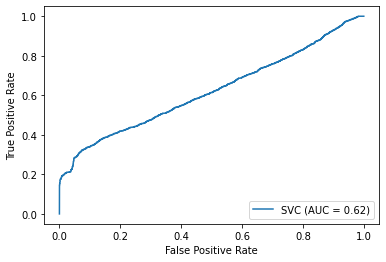

In [34]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

### SVM using GRIDSEARCH

In [ ]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

### GAUSSIAN NAIVE BAYES

Elapsed time:            0.0140 sec
Training accuracy score: 78.7849%
Test accuracy score:     79.2475%
ROC AUC score:           83.2400%


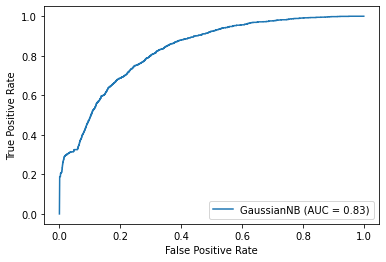

In [157]:
prob_0 = y_train[y_train ==0].shape[0]/y_train.shape[0]
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
probs = np.array([prob_0,prob_1])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

### SVM performance on feature processing and dimensionality reduction

In [120]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            87.7470 sec
Training accuracy score: 84.4793%
Test accuracy score:     83.6400%
ROC AUC score:           89.1191%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            191.4221 sec
Training accuracy score: 84.7777%
Test accuracy score:     74.9710%
ROC AUC score:           74.9006%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            104.3507 sec
Training accuracy score: 78.8180%
Test accuracy score:     78.5845%
ROC AUC score:           63.1530%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [158]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.75191678, 0.24808322]))
Elapsed time:            0.0110 sec
Training accuracy score: 79.8251%
Test accuracy score:     80.0265%
ROC AUC score:           85.7197%

PCA
GaussianNB(priors=array([0.75191678, 0.24808322]))
Elapsed time:            0.0090 sec
Training accuracy score: 80.1401%
Test accuracy score:     73.5952%
ROC AUC score:           76.0331%

Variance Threshhold
GaussianNB(priors=array([0.75191678, 0.24808322]))
Elapsed time:            0.0090 sec
Training accuracy score: 78.7849%
Test accuracy score:     79.2475%
ROC AUC score:           83.1764%


<Figure size 432x288 with 0 Axes>

## 8. YEAST DATASET

### Data Loading

In [72]:
dataset_url = os.path.join(yeast_dataset_directory, 'yeast_dataset.csv')

cols=['mcg','gvh','alm','mit','erl','pox','vac','nuc','site']
data_yeast = pd.read_csv(dataset_url,usecols=[i for i in range(1,10)],names=cols)
#data_yeast = data_yeast.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)

site_mapping = {'MIT':1, 'NUC':2, 'CYT':3
                     , 'ME1':4, 'EXC':5, 'ME2':6
                     , 'ME3':7, 'VAC':8, 'POX':9
                     , 'ERL':10}

data_yeast.site = [site_mapping[i] for i in data_yeast.site]
data_yeast.head()

data_yeast = data_yeast.replace(to_replace='?', value=np.nan)
data_yeast.dropna(inplace=True)

X = data_yeast.iloc[:,:-1]
y= data_yeast.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Plot

### Model Evaluation

### SVM

In [73]:
model,tym = svm_classification(X_train,y_train,X_test,y_test)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
svm_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            0.2115 sec
Training accuracy score: 61.9208%
Test accuracy score:     57.2391%
ROC AUC score:           82.8974%


### SVM using GRIDSEARCH

In [66]:
model,tym = svm_classification_tuned(X_train,y_train)
print(model.get_params())

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.3s finished


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 10.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [67]:
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")

Elapsed time:            6.5904 sec
Training accuracy score: 64.9537%
Test accuracy score:     54.5455%
ROC AUC score:           82.0353%


### GAUSSIAN NAIVE BAYES

In [68]:
prob_1 = y_train[y_train ==1].shape[0]/y_train.shape[0]
prob_2 = y_train[y_train ==2].shape[0]/y_train.shape[0]
prob_3 = y_train[y_train ==3].shape[0]/y_train.shape[0]
prob_4 = y_train[y_train ==4].shape[0]/y_train.shape[0]
prob_5 = y_train[y_train ==5].shape[0]/y_train.shape[0]
prob_6 = y_train[y_train ==6].shape[0]/y_train.shape[0]
prob_7 = y_train[y_train ==7].shape[0]/y_train.shape[0]
prob_8 = y_train[y_train ==8].shape[0]/y_train.shape[0]
prob_9 = y_train[y_train ==9].shape[0]/y_train.shape[0]
prob_10 = y_train[y_train ==10].shape[0]/y_train.shape[0]
probs = np.array([prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10])
model,tym = gaussian_classification(X_train,y_train,X_test,y_test,probs)
train_acc,test_acc,roc = plotModel(model,X_train,y_train,X_test,y_test)
print ("Elapsed time:            "+"{:.4f}".format(tym)+" sec")
print ("Training accuracy score: "+"{:.4f}".format(train_acc)+"%")
print ("Test accuracy score:     "+"{:.4f}".format(test_acc)+"%")
print ("ROC AUC score:           "+"{:.4f}".format(roc)+"%")
naive_bayes_info.append([tym,train_acc,test_acc,roc])

Elapsed time:            0.0029 sec
Training accuracy score: 14.5746%
Test accuracy score:     14.4781%
ROC AUC score:           74.2922%


### SVM performance on feature processing and dimensionality reduction

In [78]:
plot('svm',X_train,y_train,X_test,y_test,None)

Normalisation
SVC(probability=True, random_state=0)
Elapsed time:            0.2264 sec
Training accuracy score: 61.1626%
Test accuracy score:     54.8822%
ROC AUC score:           81.7060%

PCA
SVC(probability=True, random_state=0)
Elapsed time:            0.2234 sec
Training accuracy score: 65.7961%
Test accuracy score:     52.5253%
ROC AUC score:           79.1931%

Variance Threshhold
SVC(probability=True, random_state=0)
Elapsed time:            0.1961 sec
Training accuracy score: 61.9208%
Test accuracy score:     57.2391%
ROC AUC score:           82.8974%


<Figure size 432x288 with 0 Axes>

### GNB performance on feature processing and dimensionality reduction

In [69]:
plot('gnb',X_train,y_train,X_test,y_test,probs)

Normalisation
GaussianNB(priors=array([0.15669756, 0.29991575, 0.31676495, 0.02864364, 0.01853412,
       0.03706824, 0.10446504, 0.02021904, 0.01516428, 0.00252738]))
Elapsed time:            0.0010 sec
Training accuracy score: 14.4903%
Test accuracy score:     11.4478%
ROC AUC score:           71.5530%

PCA
GaussianNB(priors=array([0.15669756, 0.29991575, 0.31676495, 0.02864364, 0.01853412,
       0.03706824, 0.10446504, 0.02021904, 0.01516428, 0.00252738]))
Elapsed time:            0.0020 sec
Training accuracy score: 56.7818%
Test accuracy score:     24.9158%
ROC AUC score:           54.7227%

Variance Threshhold
GaussianNB(priors=array([0.15669756, 0.29991575, 0.31676495, 0.02864364, 0.01853412,
       0.03706824, 0.10446504, 0.02021904, 0.01516428, 0.00252738]))
Elapsed time:            0.0010 sec
Training accuracy score: 14.5746%
Test accuracy score:     14.4781%
ROC AUC score:           74.2922%


<Figure size 432x288 with 0 Axes>

## Compiled results of two classifiers

In [43]:
print("ESTIMATOR INFO FOR SVM CLASSIFIER")
print ("Dataset#    Time  Train_acc   Test_acc   ROC")
i=1
for item in svm_info:
    print("Dataset %d:  %.2f    %.2f      %.2f    %.2f"%(i,item[0],item[1],item[2],item[3]))
    i+=1
print("")
print("ESTIMATOR INFO FOR GAUSSIAN NAIVE BAYES")
i=1
print ("Dataset#    Time  Train_acc   Test_acc   ROC")
for item in naive_bayes_info:
    print("Dataset %d:  %.2f    %.2f      %.2f    %.2f"%(i,item[0],item[1],item[2],item[3]))
    i+=1

ESTIMATOR INFO FOR SVM CLASSIFIER
Dataset#    Time  Train_acc   Test_acc   ROC
Dataset 1:  0.51    98.87      97.67    98.36
Dataset 2:  190.30    89.80      90.09    92.32
Dataset 3:  542.42    68.62      68.39    98.19
Dataset 4:  3216.47    70.72      70.14    81.21
Dataset 5:  219.35    33.79      33.07    47.34
Dataset 6:  183.77    77.74      78.55    54.69
Dataset 7:  96.08    78.78      78.77    62.10
Dataset 8:  0.24    61.42      60.94    84.73

ESTIMATOR INFO FOR GAUSSIAN NAIVE BAYES
Dataset#    Time  Train_acc   Test_acc   ROC
Dataset 1:  0.00    97.80      97.75    98.95
Dataset 2:  0.03    84.66      84.66    84.73
Dataset 3:  0.02    94.23      94.04    99.36
Dataset 4:  0.05    43.59      43.09    71.08
Dataset 5:  0.02    33.61      32.92    52.98
Dataset 6:  0.02    38.87      39.33    68.37
Dataset 7:  0.01    78.78      79.18    81.50
Dataset 8:  0.01    18.37      16.16    72.69
